In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\User\Desktop\project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [45]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch

In [46]:
from datetime import datetime, timedelta
from elasticsearch import Elasticsearch
import pandas as pd

# Connect to Elasticsearch
es = Elasticsearch(["http://localhost:9200"])

# Define the time range (last 30 days)
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=35)
symbol = "BTC/USD"


# Elasticsearch query for the last 30 days
query = {
    "size": 10000,  # Adjust if needed
    "query": {
        "bool": {
            "must": [
                {"term": {"symbol": symbol}},
                {
                    "range": {
                        "t": {
                            "gte": start_time.strftime("%Y-%m-%dT%H:%M:%S"),
                            "lte": end_time.strftime("%Y-%m-%dT%H:%M:%S"),
                            "format": "yyyy-MM-dd'T'HH:mm:ss"
                        }
                    }
                }
            ]
        }
    },
    "sort": [
        {"t": {"order": "asc"}}  # Change to "desc" for descending order
    ]
}

# Fetch data
response = es.search(index="trading", body=query, scroll="2m")

# Extract and format data
hits = [hit["_source"] for hit in response["hits"]["hits"]]
data = pd.DataFrame(hits)

# Convert timestamp to datetime
# data['t'] = pd.to_datetime(data['t']).dt.tz_localize(None)

# data.tail()
# data.to_csv("trading_data.csv", index=False)


In [47]:
data['market'] = data['c'] * data['v']
import numpy as np 
# close -> log_close
data['volatilite'] = data['h'] - data['l']
# market -> log_market
#crypto['log_market'] = np.log(crypto.market)
data['log_market'] = np.log(data.market)
data['rolling_mean_24h'] = data['c'].rolling(window=24, min_periods=1).mean()
data['rolling_std_24h'] = data['c'].rolling(window=24, min_periods=1).std()
# Spread

data['spread'] = (data.h - data.l) / data.c
# return -> log (close / open)
data['log_return'] = np.log(data.c / data.c.shift(1))

data.dropna(inplace=True)

print(data.head(1))
print("============================")
print(data.tail(1))

          c          h         l  n            o                     t  \
1  100644.9  100978.11  100622.8  4  100783.1925  2025-01-07T13:00:00Z   

          v             vw   symbol                         es_id      market  \
1  0.008311  100851.283869  BTC/USD  BTC/USD_2025-01-07T13:00:00Z  836.418801   

   volatilite  log_market  rolling_mean_24h  rolling_std_24h   spread  \
1      355.31    6.729129      100688.22175        61.266206  0.00353   

   log_return  
1   -0.000861  
             c           h          l  n          o                     t  \
756  96662.435  96830.2956  96407.405  6  96507.579  2025-02-08T00:00:00Z   

            v            vw   symbol                         es_id  \
756  0.002088  96694.062485  BTC/USD  BTC/USD_2025-02-08T00:00:00Z   

         market  volatilite  log_market  rolling_mean_24h  rolling_std_24h  \
756  201.832421    422.8906    5.307438      97356.035613       893.257673   

       spread  log_return  
756  0.004375    0.001034  


c:\Users\User\Desktop\project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


12:19:41 - cmdstanpy - INFO - Chain [1] start processing
12:19:42 - cmdstanpy - INFO - Chain [1] done processing


     Model Target      MAE      RMSE  MAPE (%)
0  Prophet      h  1.39406  1.512286  0.001412


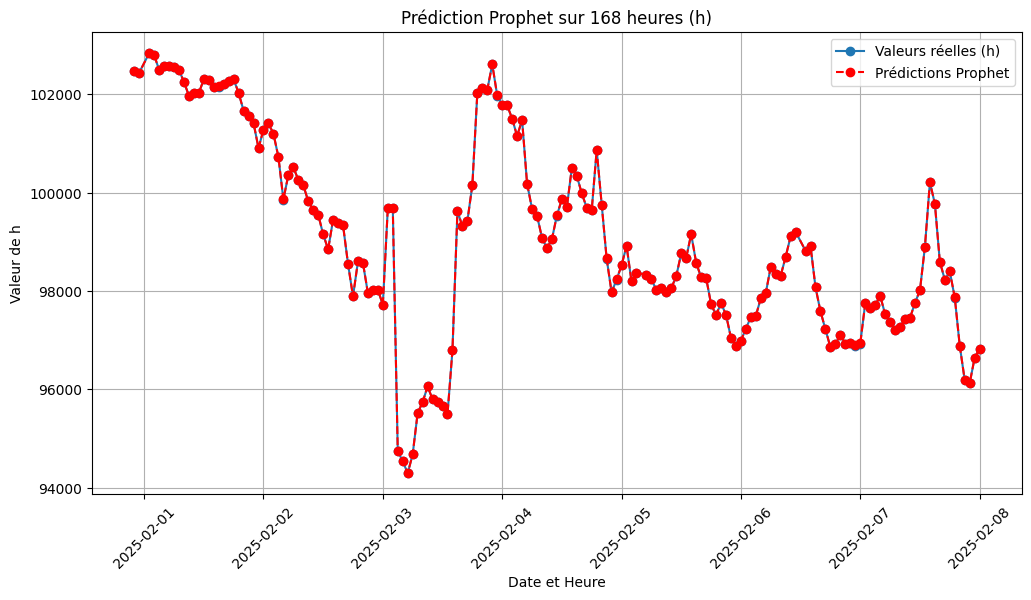

                      t            h   prophet_pred
586 2025-01-31 22:00:00  102471.2400  102470.875574
587 2025-01-31 23:00:00  102433.5300  102433.210541
589 2025-02-01 01:00:00  102828.2100  102828.077192
590 2025-02-01 02:00:00  102797.2700  102797.193092
591 2025-02-01 03:00:00  102497.2000  102497.133467
..                  ...          ...            ...
752 2025-02-07 20:00:00   96890.4995   96891.938626
753 2025-02-07 21:00:00   96192.8540   96194.138041
754 2025-02-07 22:00:00   96125.7000   96126.961350
755 2025-02-07 23:00:00   96644.1000   96645.463225
756 2025-02-08 00:00:00   96830.2956   96831.687688

[168 rows x 3 columns]


In [48]:
def get_exog_vars(target):
    """
    Sélectionne dynamiquement les variables exogènes en fonction de la variable cible.
    """
    features = {
        'c': ['o', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'o': ['c', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'h': ['o', 'c', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'l': ['o', 'h', 'c', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
    }
    return features.get(target, [])

def train_prophet(train_data, target='c'):
    """
    Entraîne un modèle Prophet sur les données fournies.

    Paramètres :
    - train_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour l'entraînement ('c', 'o', etc.).

    Retourne :
    - Le modèle Prophet entraîné
    """
    exog_vars = get_exog_vars(target)

    # Vérifier si la colonne de timestamp existe
    timestamp_col = 't' if 't' in train_data.columns else 'timestamp'
    train_data = train_data.copy()  # Éviter les warnings SettingWithCopyWarning
    train_data[timestamp_col] = pd.to_datetime(train_data[timestamp_col]).dt.tz_localize(None)

    # Préparer les données pour Prophet
    prophet_data = train_data[[timestamp_col, target]].rename(columns={timestamp_col: 'ds', target: 'y'})

    # Ajouter les variables exogènes
    for var in exog_vars:
        if var in train_data.columns:
            prophet_data[var] = train_data[var]

    # Définition du modèle
    model = Prophet()

    # Ajouter les régressseurs exogènes au modèle
    for var in exog_vars:
        if var in train_data.columns:
            model.add_regressor(var)

    # Entraînement du modèle
    try:
        model.fit(prophet_data)
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle Prophet : {e}")
        return None

    return model

def evaluate_prophet(model, test_data, target='c'):
    """
    Évalue un modèle Prophet en faisant des prédictions et en calculant les métriques.

    Paramètres :
    - model : Modèle Prophet entraîné.
    - test_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour la prédiction ('c', 'o', etc.).

    Retourne :
    - Un DataFrame avec les valeurs réelles et prédites.
    """
    if model is None:
        print("Modèle non entraîné. Impossible d'évaluer.")
        return None

    exog_vars = get_exog_vars(target)

    # Vérifier si la colonne de timestamp existe
    timestamp_col = 't' if 't' in test_data.columns else 'timestamp'
    test_data = test_data.copy()  # Éviter SettingWithCopyWarning
    test_data[timestamp_col] = pd.to_datetime(test_data[timestamp_col]).dt.tz_localize(None)

    # Préparer les données de prévision
    future = test_data[[timestamp_col]].rename(columns={timestamp_col: 'ds'})

    # Ajouter les régressseurs exogènes
    for var in exog_vars:
        if var in test_data.columns:
            future[var] = test_data[var]

    # Faire les prédictions
    try:
        forecast = model.predict(future)
        test_data['prophet_pred'] = forecast['yhat'].values
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None

    # Calcul des métriques d’évaluation
    mae = mean_absolute_error(test_data[target], test_data['prophet_pred'])
    rmse = np.sqrt(mean_squared_error(test_data[target], test_data['prophet_pred']))
    mape = np.mean(np.abs((test_data[target] - test_data['prophet_pred']) / test_data[target])) * 100

    # Affichage des métriques
    metrics_results = pd.DataFrame({
        "Model": ["Prophet"],
        "Target": [target],
        "MAE": [mae],
        "RMSE": [rmse],
        "MAPE (%)": [mape],
    })
    print(metrics_results)

    # Tracé des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(test_data[timestamp_col], test_data[target], marker='o', linestyle='-', label=f'Valeurs réelles ({target})')
    plt.plot(test_data[timestamp_col], test_data['prophet_pred'], marker='o', linestyle='--', label='Prédictions Prophet', color='red')

    plt.xlabel("Date et Heure")
    plt.ylabel(f"Valeur de {target}")
    plt.title(f"Prédiction Prophet sur {len(test_data)} heures ({target})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    return test_data[[timestamp_col, target, 'prophet_pred']]

# ----------- Utilisation -----------

# Nettoyage des données
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Vérifier si la colonne timestamp existe
timestamp_col = 't' if 't' in data.columns else 'timestamp'
data = data.copy()  # Éviter SettingWithCopyWarning
data[timestamp_col] = pd.to_datetime(data[timestamp_col]).dt.tz_localize(None)

# Définition des périodes d'entraînement et de test en heures
train_hours = 30 * 24  # 30 jours en heures
forecast_hours = 7 * 24  # 7 jours en heures
train = data.iloc[-(train_hours + forecast_hours):-forecast_hours].copy()
test = data.iloc[-forecast_hours:].copy()

# Sélection de la variable cible
target_variable = 'h'  # 'c', 'o', etc.

# Entraînement du modèle
prophet_model = train_prophet(train, target=target_variable)

# Évaluation et affichage des résultats
if prophet_model:
    results = evaluate_prophet(prophet_model, test, target=target_variable)
    if results is not None:
        print(results)